# Banknote Fraud Detection

This notebook goes over the process of using a decision tree to perform a binary classification on banknotes. These banknotes will be labeled as either fraudulent or not (class 1 and 0, respectively).

---

## **Data Description**:

The data was downloaded from [this source](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#). 

Extracted from images were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.

**Attribute Information**:
1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import scipy.io
import random

In [2]:
def import_data(split=0.8, shuffle=False):    
    """[summary]

    Args:
        split (float, optional): The proportion of the data used for training.
            Defaults to 0.8.
        shuffle (bool, optional): Randomizes data. Defaults to False.
    Returns:
        X_train, y_train, X_test, y_test (np.ndarray): Feature and target matrices
            for the training and test sets.
    """    
    # Read in the data as a pd.DataFrame
    data = pd.read_csv(
        'banknote_data.txt',
        sep=",",
        header=None,
        names=["x0", "x1", "x2", "x3", "y"])
    
    # Split data into 80-20 train-test split
    train_size = round(split * len(data))
    
    if shuffle == True:
        row_number = data.index.tolist()
        train_rows = random.sample(
            population=row_number, 
            k=train_size)
        train_data = data.loc[train_rows]
        test_data = data.drop(train_rows)
    else:
        train_data, test_data = np.split(data, [train_size])
        print("data imported")
    X_train = train_data[['x0', 'x1', 'x2', 'x3']].to_numpy()
    y_train = train_data[['y']].to_numpy().flatten()
    X_test = test_data[['x0', 'x1', 'x2', 'x3']].to_numpy()
    y_test = test_data[['y']].to_numpy().flatten()
    return X_train, y_train, X_test, y_test

In [3]:
class Node:
    """Each node of our decision tree will hold values such as left
    and right children, the data and labels being split on, the 
    threshold value & index in the dataframe for a particular 
    feature, and the uncertainty measure for this node"""
    def __init__(self, data, labels, depth):
        """
        data: X data
        labels: y data
        depth: depth of tree
        """
        self.left = None
        self.right = None

        self.data = data
        self.labels = labels
        self.depth = depth

        self.threshold = None # threshold value
        self.threshold_index = None # threshold index
        self.feature = None # feature as a NUMBER (column number)
        self.label = None # y label
        self.uncertainty = None # uncertainty value

**Entropy and Gini Calculations**:
$X=\{ x_i\}_i^n$ and $\sum\limits_i P(x_i) = 1$ $\implies$
$$\text{Entropy, }\;\; E(X) = \sum\limits_{i=1}^n  P(x_i) \cdot \log_2(P(x_i)) $$

$$\text{Total Entropy, }\;\; E_{tot}(X) = \sum\limits_{i=1}^n P(x_i)\cdot E(X) $$

$$\text{Gini impurity, }\;\; G(X)=\sum\limits_{i=1}^nP(x_i)\sum\limits_{k\neq i}P(x_k) = \sum\limits_{i=1}^nP(x_i)(1-P(x_i)) = 1-\sum\limits_{i=1}^n P(x_i)^2  $$ 

In [4]:
# Entropy and Gini Calculations
def entropy(y_labels):
    _, fraud_count = np.unique(y_labels, return_counts=True)
    p_i = fraud_count / fraud_count.sum() # probability (array) of each class
    entropy = np.sum(p_i * -np.log2(p_i))
    return entropy

def gini(y_labels):
    _, fraud_count = np.unique(y_labels, return_counts=True)
    p_i = fraud_count / fraud_count.sum() # probability (array) of each class
    gini = 1 - np.sum(p_i**2)
    return gini
    
def total_entropy(partition_0, partition_1):
    n = len(partition_0) + len(partition_1)
    prob_part0 = len(partition_0) / n # probability of partition 0
    prob_part1 = len(partition_1) / n # probabiltiy of partition 1 
    tot_entropy = (prob_part0 * entropy(partition_0)
        + prob_part1 * entropy(partition_1) )
    return tot_entropy

In [27]:
class DecisionTree:
    def __init__(self, K=5, verbose=False):
        """
        K: number of features to split on 
        """
        self.root = None
        self.K = K
        self.verbose = verbose

    def buildTree(self, data, labels):
        """Builds tree for training on data. Recursively called _buildTree"""
        self.root = Node(data, labels, 0)
        if self.verbose:
            print("Root node shape: ", data.shape, labels.shape)
        self._buildTree(self.root)

    def _buildTree(self, node):
        # get uncertainty measure and feature threshold
        node.uncertainty = self.get_uncertainty(node.labels)
        self.get_feature_threshold(node)
        
        # sort feature for return
        index = node.data[:, node.feature].argsort()
        node.data = node.data[index]
        node.labels = node.labels[index]      
        
        label_distribution = np.bincount(node.labels)       
        if self.verbose:
            print("Node uncertainty: %f" % node.uncertainty)
        
        # Split left and right if threshold is not a minima of the feature 
        if (node.threshold_index == 0 or 
            node.threshold_index == node.data.shape[0] or
            len(label_distribution) == 1):
            node.label = (node.labels[0] if len(label_distribution) == 1 
                          else np.argmax(label_distribution) )
        else:
            node.left = Node(node.data[:node.threshold_index],
                             node.labels[:node.threshold_index],
                             node.depth + 1)
            node.right = Node(node.data[node.threshold_index:],
                              node.labels[node.threshold_index:],
                              node.depth + 1)
            node.data = None
            node.labels = None
            
            # If the node is in the last layer of tree, assign predictions
            if node.depth == self.K:
                if len(node.left.labels) == 0:
                    node.right.label = np.argmax(np.bincount(node.right.labels))
                    node.left.label = 1 - node.right.label
                elif len(node.right.labels) == 0:
                    node.left.label = np.argmax(np.bincount(node.left.labels))
                    node.right.label = 1 - node.left.label
                else:
                    node.left.label = np.argmax(np.bincount(node.left.labels))
                    node.right.label = np.argmax(np.bincount(node.right.labels))
                return

            else: # Otherwise continue training the tree
                self._buildTree(node.left)
                self._buildTree(node.right)

    def predict(self, data_pt):
        return self._predict(data_pt, self.root)

    def _predict(self, data_pt, node):
        feature = node.feature
        threshold = node.threshold
        if node.label is not None:
            return node.label
        elif data_pt[node.feature] < node.threshold:
            return self._predict(data_pt, node.left)
        elif data_pt[node.feature] >= node.threshold:
            return self._predict(data_pt, node.right)

    def get_feature_threshold(self, node):
        """ This function finds the feature that gives the largest information
        gain, then updates node.threshold, node.threshold_index, and 
        node.feature, a number representing the feature.
        
        return: None
        """
        node.threshold = 0
        node.threshold_index = 0
        node.feature = 0

        gain, index, feature = 0, 0, 0 
        for k in range(len(node.data[0])):
            d = np.argsort(node.data[:, k])
            node.labels = node.labels[d]
            node.data = node.data[d]
            for j in range(len(node.data)):
                if self.getInfoGain(node, j) > gain:
                    gain, index, feature = self.getInfoGain(node, j), j, k
        feat = np.argsort(node.data[:, feature])
        node.data = node.data[feat]
        node.labels = node.labels[feat]
        
        node.threshold = node.data[index, feature]
        node.threshold_index = index
        node.feature = feature 

    def getInfoGain(self, node, split_index):
        """Gets information gain at a given node (decision) in the tree.

        Args:
            node (Node): The node at which the information gain will be evaluated.
            split_index (int): Index in the feature column that we 
                split the classes on

        Returns:
            infogain (float): information gain
        """
        left_uncertainty = self.get_uncertainty(node.labels[:split_index]) 
        right_uncertainty = self.get_uncertainty(node.labels[split_index:])
        
        n = len(node.labels)
        w1 = left_uncertainty * (split_index + 1) / n
        w2 = right_uncertainty * (n - (split_index + 1)) / n
        
        start_entropy = self.get_uncertainty(node.labels)
        conditional_entropy = w1 + w2 
        infogain = start_entropy - conditional_entropy
        return infogain

    def get_uncertainty(self, labels, metric="gini"):
        """Get uncertainty value using either entropy OR gini index. 
        
        Args:
            labels (ndarray): Training labels, or targets .
            metric (str, optional): [description]. Defaults to "gini".

        Returns: uncertainty (float)
        """
        
        if labels.shape[0] == 0:
            return 1
        if metric =="gini":    
            uncertainty = gini(labels)
        if metric == "entropy":
            uncertainty = entropy(labels)
        
        return uncertainty

    def printTree(self):
        """Prints the tree including threshold value and feature name"""
        self._printTree(self.root)

    def _printTree(self, node):
        if node is not None:
            if node.label is None:
                print("\t" * node.depth, "(%d, %d)" 
                      % (node.threshold, node.feature))
            else:
                print("\t" * node.depth, node.label)
            self._printTree(node.left)
            self._printTree(node.right)

    def tree_evaluate(self, X_train, labels, X_test, y_test, verbose=False): 
        #---------
        # Training
        #---------
        n = X_train.shape[0] # number of training samples
        count = 0 # number of accurate predictions
        
        # for all training samples
        for i in range(n):
            # if the prediction matches the target,
            if self.predict(X_train[i]) == labels[i]:
                count += 1
        
        accuracy_train = (count / n) * 100
        if verbose == True:
            print(f"Training accuracy: {(count / n) * 100:.1f}% "
              + f"on {n} samples." )
        #---------
        # Testing
        #---------
        n = X_test.shape[0] # number of test samples
        count = 0 # number of accurate predictions
        
        # for all test samples
        for i in range(n):
            # if the prediction matches the target,
            if self.predict(X_test[i]) == y_test[i]:
                # 
                count += 1
        accuracy_test = (count / n) * 100
        if verbose == True:
            print(f"Test accuracy: {(count / n) * 100:.1f}% "
                  + f"on {n} samples." )

        return accuracy_train, accuracy_test

## Running the tree

The depth of the tree, $K$, is the number of features that the tree will split on. Varying the value of $K$ affects the model accuracy, but there are diminshing returns as $K$ is increased more and more.

Which feature gives the largest information gain? Which feature is the least useful for the decision tree?

In [29]:
X_train, y_train, X_test, y_test = import_data(split=0.8, shuffle=True)

tree = DecisionTree(K=7, verbose=False)
tree.buildTree(X_train, y_train)
tree.tree_evaluate(X_train, y_train, X_test, y_test, verbose=True)

Training accuracy: 100.0% on 1098 samples.
Test accuracy: 98.9% on 274 samples.


(100.0, 98.90510948905109)

In [56]:
def plot_accuracy_vals(K_max=8, shuffle=True):
    """
    Args:
        K_max (int): Maximum tree depth to evaluate accuracy values on.
        shuffle (bool, optional): Chooses whether to randomize datasets.
            Defaults to True.
    """
    train_accuracies, test_accuracies = [], []
    for K_val in range(K_max + 1):
        print(f"Evaluating K={K_val}")
        X_train, y_train, X_test, y_test = import_data(split=0.8, shuffle=shuffle)
        tree = DecisionTree(K=K_val, verbose=False)
        tree.buildTree(X_train, y_train)
        train_accuracy, test_accuracy = tree.tree_evaluate(X_train, y_train, X_test, y_test)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Stop looping if tree overfits
        if K_val >= 1:
            overfit = test_accuracies[-1] < test_accuracies[-2]
            if overfit:
                print(f"Decision tree overfits at depth {K_val}")
                break
    K_vals = np.arange(K_val + 1)
    
    global fig, ax
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(K_vals, train_accuracies, '-', label="train")
    ax.plot(K_vals, test_accuracies, '-', label="test")
    ax.set(title="Decision Tree Accuracy vs. Tree Depth",
           xlabel="Depth", ylabel="Accuracy")
    ax.legend()
    plt.show()

Evaluating K=0
Evaluating K=1
Evaluating K=2
Evaluating K=3
Evaluating K=4
Decision tree overfits at depth 4


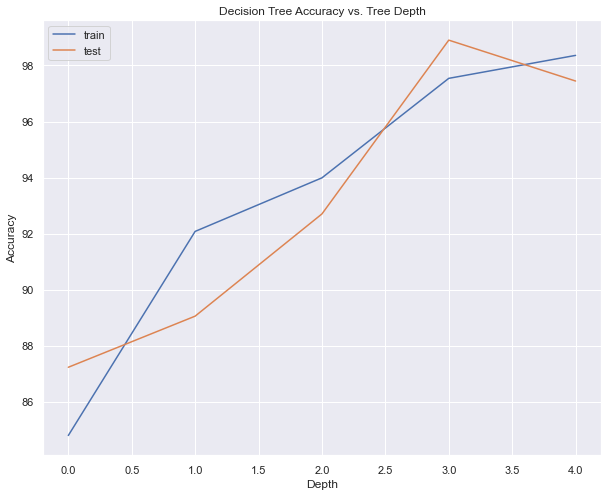

In [57]:
plot_accuracy_vals()

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
sklearn_tree = DecisionTreeClassifier(max_depth = 4)
sklearn_tree.fit(X_train, y_train)
y_pred = sklearn_tree.predict(X_test)
sklearn_accuracy = accuracy_score(y_test, y_pred) * 100

# Custom decision tree
tree = DecisionTree(K=4, verbose=False)
tree.buildTree(X_train, y_train)
_, custom_accuracy = tree.tree_evaluate(X_train, y_train, 
                                        X_test, y_test, verbose=False)

print(f"Sci-kit learn CART accuracy: {sklearn_accuracy:.2f}")
print(f"Custom CART accuracy: {custom_accuracy:.2f}")

Sci-kit learn CART accuracy: 96.35
Custom CART accuracy: 97.81


My custom decision tree performed better on the validation set. 

To see which algorithm is more robust in general, I'll need to use cross validation.